<center><h1>CS 532 Final Project</h1></center>
<center><h1>Using Machine Learning to Solve Mass Spectrometry Problems</h1></center>
<br>
<center><h3>Nik Burmeister | Yusi Cui | John Mccloskey</h3></center>

# Activity Background

We are now going to apply PCA and clustering to the problem defined in our lecture slides. We will then formulate a least squares classifier to train our weights. We will then optimize using cross validation.

Let's get to it!

# Step 1: 
# Let's start with importing some popular python data analysis packages

Please execute the cell below. You can execute cells by clicking the cell so that your cursor is in the cell and holding shift and pressing enter.This will import, among other things, numpy and pandas-two widely used data analysis packages.  

In [18]:
import pandas as pd
import numpy as np
from IPython.display import Image

# Step 2: 
# Read In Mass Spectrometry Data

Presented below is a function that reads in mass spectrometry data. For convenience we have converted the data into CSV files. 

Please execute the function below to read in two data sets: one containing data for a control mouse and one for an injured mouse.

In [19]:
def read_spectrometry_data(control_file_name, injured_file_name):
    """
    HELPER METHOD FOR READING DATA FROM CSV
    :return:
    """
    df_intensities = pd.read_csv('rawData/{control_file_name}.csv'.format(control_file_name=control_file_name),
                                 index_col=0)
    df_mass = pd.read_csv('rawData/{injured_file_name}.csv'.format(injured_file_name=injured_file_name), 
                          index_col=0)
    return df_mass, df_intensities

### Notice that we are only loading control data. As mentioned before, there are mass and intensity data files for both control and injured data.

### Note: These files are quite large (>100mb) so loading the data may take a few seconds.

In [20]:
CONTROL_FILE_NAME = "Intensity_Control_Day03_01"
INJURED_FILE_NAME = "Mass_Control_Day03_01"
df_mass, df_intensities = read_spectrometry_data(CONTROL_FILE_NAME, INJURED_FILE_NAME)

FileNotFoundError: File b'rawData/Intensity_Control_Day03_01.csv' does not exist

#### Let's inspect the dimensions of the mass dataframe (df_mass). Execute the following code below: df_mass.head()

In [21]:
df_mass.head()

NameError: name 'df_mass' is not defined

### Data Background: 
The matrix you just loaded is 10,000 x 892. Each column is a feature vector. So we have almost 900 data samples, and 10,000 features for each sample.

Furthermore, each sample represents a 'pixel' in the image. An image has around 900 pixels, but sometimes the size varies. 

### Let's see what a feature vector (a column) looks like:

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
x = df_mass.iloc[:, 0]
y = df_intensities.iloc[:, 0]
plt.figure(1)
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
colors = np.random.rand(3)
scatter(x.values, y.values,  c=colors)
plt.xlabel('MZS')
plt.ylabel('Intensity')

NameError: name 'df_mass' is not defined

## Recap:

Our control data consists of intensities (y axis) and mass-to-charge ratios (x axis). This data is is located in two dataframes: df_mass and df_intensities. Each column in these dataframes represent a sample. Each sample represents a pixel in the image. An image has a dimension around 30x30 pixels. We have illustrated this in the diagram below:

![title](img/pixel.png?1)

# Step 3:
# Let's Clean Some Data

As you have seen, our data set is quite large. Furthermore, for a given pixel, there is a lot of data we do not need. We are interested in the "peak" intensities for a given pixel. This will tell us the most abundant molecules for a given tissue region. In order to reduce our data set, we will use the signal function from scipy to find the indexes where the peaks occur. We will then filter the data by these peaks.

Execute the following cell to find the peaks and graph the resulting data:

In [23]:
import scipy.signal as signal

def find_pixel_peaks(x, y):
    pixel = pd.DataFrame({'mzs': x.values, 'intensities': y.values})
    peaks = signal.find_peaks(y, height=50000)
    pixel = pixel[pixel.index.isin(peaks[0])]
    return pixel

pixel_peaks = find_pixel_peaks(df_mass.iloc[:, 0], df_intensities.iloc[:, 0])
plt.figure(2)
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
scatter(pixel['mzs'], pixel['intensities'],  c=[0.00903845, 0.27883565, 0.57728387, 0.68528783])
plt.xlabel('MZS')
plt.ylabel('Intensity')

NameError: name 'df_mass' is not defined

As you can see, the signal function finds the peak intensities. We set a hard threshold of 50,000, meaning the function not consider anything below a peak. Note: for this purposes of this exercise this threshold was set by observation. This will eventually allow us to use sparse regularization to find the important features.

### Data Alignment issues

Our goal will eventually be to compare the control data to the injured data. Another data issue is that our MZS axes may not align when combining the control and sample data to do a regression. In order to fix this, we will bin the data. For each bin, we will add all intensities that fall in the bin's range. Other combination mathods, such as taking the mean, median, and max, could also be used. For the purposes of this exercise, we will only consider adding the intensities.

Execute the code below. The following code will iterate over each pixel in the image and find the peaks. After finding the peaks of each pixel, we will make a linspace of 250 bins. We then iterate over the bins, find all intensities in that range, and sum them together.

#### Note: the following code may take up to 4 min to run

In [24]:
from numpy import linspace

# FIND THE NUMBER OF SAMPLES
pixel_count = len(df_mass.columns)

# CREATE A DATAFRAME THAT WILL HOLD ALL FILTER PIXELS
master_df = pd.DataFrame()

# FIND PEAKS FOR EACH PIXEL, ADD TO MASTER_DF
for i in range(pixel_count):
    pixel_x = df_mass.iloc[:, i]
    pixel_y = df_intensities.iloc[:, i]
    df = find_pixel_peaks(pixel_x, pixel_y)
    df['pixel_id'] = i
    master_df = master_df.append(df, ignore_index=True)

# NUMBER OF BINS FOR THE MZS AXIS
number_of_bins = 250
# PHYSICAL MIN AND MAX OF AXIS
min_mzs = 450
max_mzs = 1000
# MAKE THE LINSPACE
bins = linspace(min_mzs, max_mzs, number_of_bins)
col_set = list(range(pixel_count))

# CREATE NEW DATAFRAME WHERE COLUMNS ARE THE BINS
aggregated_df = pd.DataFrame(columns=list(bins[:-1]))

for i in col_set:
    curr_pixel = master_df[master_df['pixel_id'] == i]
    pixel_binned = {}
    for index in range(1, len(bins)):
        lower_bound = bins[index - 1]
        upper_bound = bins[index]
        curr_bin = curr_pixel[curr_pixel['mzs'].between(lower_bound, upper_bound)]
        bin_intensity = curr_bin['intensities'].sum()
        pixel_binned[lower_bound] = bin_intensity
    temp = pd.DataFrame([pixel_binned])
    aggregated_df = aggregated_df.append(temp, ignore_index=True)

NameError: name 'df_mass' is not defined

### Run the following code. Inspect the aggregated_df data. What do you notice about the shape?

In [25]:
aggregated_df.head()

NameError: name 'aggregated_df' is not defined

In [26]:
aggregated_df.values.shape

NameError: name 'aggregated_df' is not defined

As seen above, we have reduced our data set from 10,000x892 to 892x250.

# Step 4
# PCA, Clustering, and Building a Classifier

We will now use machine learning techniques that we studied in class to find the important features in our data, group them by cluster, and then try to classify injured vs uninjured samples.

Let's do it!

### PCA

As you have seen, data cleanup takes time. Also, 250 bins may be too small, and cause us to lose important information. For the purposes of this activity, we have prepared a data set with 1000 bins. 

#### First, import some packages:

In [27]:
from numpy import linspace, dot, transpose
from numpy.linalg import svd, pinv
from sklearn.cluster import KMeans

#### Go ahead and load in the data:

In [28]:
#df_control_feature_set = pd.read_csv('featureData/aggregated_feature_table_control_day03_01.csv', index_col=0)
df_control_feature_set = pd.read_csv(r"\\wfs1\users$\mccloskey\Downloads\csvData-20190806T210426Z-001\csvData\aggregates (bin=250)\Control_Day03_01_30x30_aggregated.csv",index_col=0)

#### Now center and standardize the data

In [62]:
df_control_feature_set_standardized = (df_control_feature_set - df_control_feature_set.mean()) / df_control_feature_set.std()
df_control_feature_set_standardized = df_control_feature_set_standardized.fillna(0)
df_control_feature_set_standardized.head()
df_control_feature_set.mean()

450.0                 469531.849362
452.20883534136544     19132.752773
454.41767068273094    134101.538420
456.6265060240964       7626.442804
458.83534136546183     21423.626649
461.04417670682733     79796.755842
463.2530120481928      62870.843329
465.4618473895582      44800.540530
467.6706827309237      13228.758963
469.87951807228916    122381.429865
472.0883534136546          0.000000
474.2971887550201        446.858485
476.50602409638554     11312.549900
478.714859437751        4145.489718
480.9236947791165      16517.520530
483.13253012048193      6170.355968
485.3413654618474     107104.070534
487.5502008032129      38649.775825
489.7590361445783          0.000000
491.96787148594376       821.871949
494.1767068273092     145424.300226
496.3855421686747      39902.501389
498.59437751004015      6234.130443
500.80321285140565     55543.763459
503.0120481927711        371.383750
505.22088353413653      3113.650161
507.429718875502       65230.576610
509.6385542168675      96430

### SVD and KMeans

We will now find the SVD of the matrix. We will then use the SVD to approximate the data in 2-dimensions.Finally, we will run K-Means on the resulting coordinates with three clusters. We will then plot the resulting K-Means labels using plt.imshow.

#### plt.imshow: this plotting function takes the cluster labels for each pixel and plots them. Therefore, our image should have three colors, each corresponding to a cluster

In [79]:
# FIND THE SVD, NOTE V IS RETURNED TRANSPOSED
[U, S, V] = svd(df_control_feature_set_standardized.values)
# CREATE A DIAG MATRIX
S_DIAG = np.diag(S)
# COMPUTE THE RANK 2 APPOIMATION TO FIND THE COORDINATES
dim_red_data = dot(S_DIAG[:2, :2], U[:, :2].transpose()).transpose()


In [97]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering().fit(dim_red_data)
labels = sc.labels_

In [91]:
from sklearn.cluster import DBSCAN
db = DBSCAN().fit(dim_red_data)
labels = db.labels_

Text(0,0.5,'Singular Vector 2')

<Figure size 432x288 with 0 Axes>

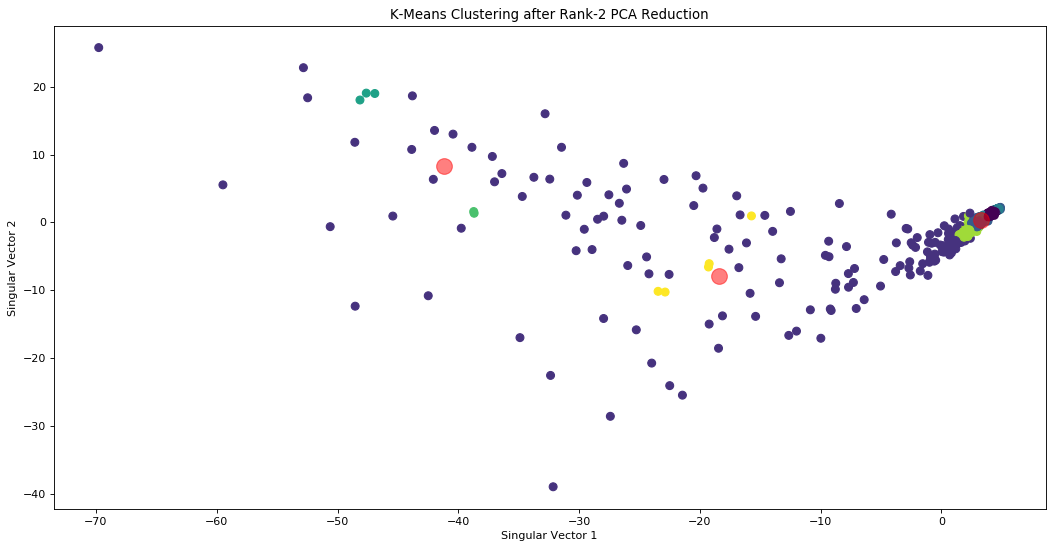

In [99]:
df_clusters = pd.DataFrame(dim_red_data)
df_clusters['clusters'] = labels
x = df_clusters[0]
y = df_clusters[1]

centers[:, 0], centers[:, 1] = centers[:, 0], centers[:, 1]
plt.figure(2)
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x, y, c=df_clusters['clusters'], s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('K-Means Clustering after Rank-2 PCA Reduction')
plt.xlabel('Singular Vector 1')
plt.ylabel('Singular Vector 2')

In [94]:
# RUN KMeans WITH 3 CLUSTERS
kmeans = KMeans(n_clusters=3, n_init=15)
kmeans.fit(dim_red_data)
y_kmeans = kmeans.predict(dim_red_data)
df_clusters = pd.DataFrame(dim_red_data)
df_clusters['clusters'] = y_kmeans

Text(0,0.5,'Singular Vector 2')

<Figure size 432x288 with 0 Axes>

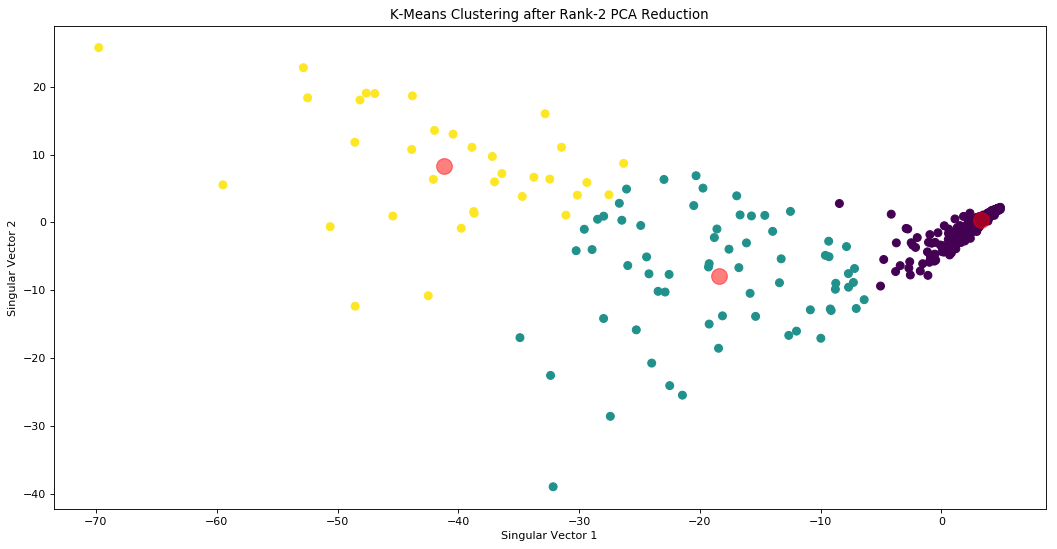

In [95]:
x = df_clusters[0]
y = df_clusters[1]

centers = kmeans.cluster_centers_
centers[:, 0], centers[:, 1] = centers[:, 0], centers[:, 1]
plt.figure(2)
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x, y, c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('K-Means Clustering after Rank-2 PCA Reduction')
plt.xlabel('Singular Vector 1')
plt.ylabel('Singular Vector 2')

#### We have 3 clusters and 3 respective centroids. Each data point represents a pixel reduces to 2-dimensions. 

### Let's try and take each pixels assigned cluster label and plot it as an image:

<Figure size 432x288 with 0 Axes>

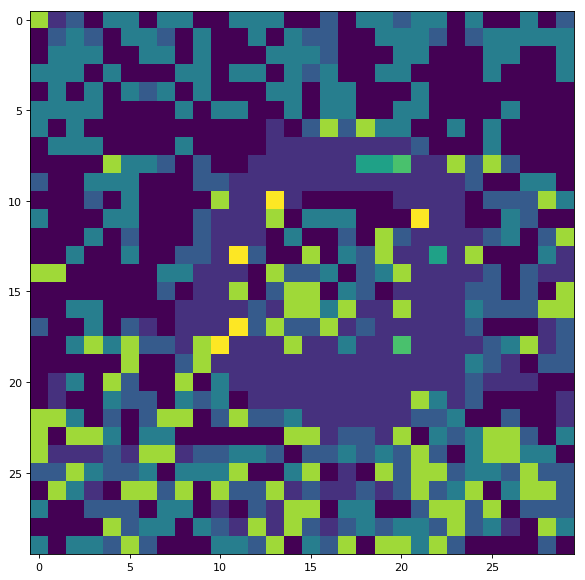

In [100]:
plt.figure(3)
plt.figure(figsize=(9, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(df_clusters['clusters'].values.reshape(30, 30))
plt.show()

### Look familiar?

<img src="img/3D-1 control.png" style="width: 200px;"/>

### Now we can distinguish between areas of interest (donut shape of cells) and noninterest (background)

In [35]:
# our current clusters are the 
df_clusters = df_control_feature_set_standardized
df_clusters['clusters'] = y_kmeans
# Get the clusters and count of pixels in each cluster
unique, counts = np.unique(y_kmeans, return_counts=True)
cluster_counts = dict(zip(unique, counts))
# Assign the cluster with the highest pixel count as the white_space
white_space_key = max(cluster_counts, key=cluster_counts.get)
# Remove white space
df_remove_white_space = df_clusters[df_clusters['clusters'] != white_space_key]
del df_remove_white_space['clusters']

In [63]:
labels = df_remove_white_space.mean().index.values.tolist()
y = df_remove_white_space.mean().values
x = [float(l) for l in labels]
df_remove_white_space.mean()

450.0                 2.550177
452.20883534136544    0.112974
454.41767068273094    2.553630
456.6265060240964     2.282633
458.83534136546183    2.371706
461.04417670682733    2.427319
463.2530120481928     2.567576
465.4618473895582     2.382891
467.6706827309237     2.441075
469.87951807228916    2.387722
472.0883534136546     0.000000
474.2971887550201     0.705661
476.50602409638554    2.208195
478.714859437751      1.850400
480.9236947791165     2.138659
483.13253012048193    2.055461
485.3413654618474     2.592366
487.5502008032129     2.021859
489.7590361445783     0.000000
491.96787148594376    0.916675
494.1767068273092     2.442609
496.3855421686747     2.369438
498.59437751004015    1.734108
500.80321285140565    2.029110
503.0120481927711     0.412125
505.22088353413653    1.715003
507.429718875502      2.372178
509.6385542168675     2.392490
511.8473895582329     2.085610
514.0562248995984    -0.047159
                        ...   
935.9437751004016     0.000000
938.1526

Text(0,0.5,'Standardized Summed Intensity')

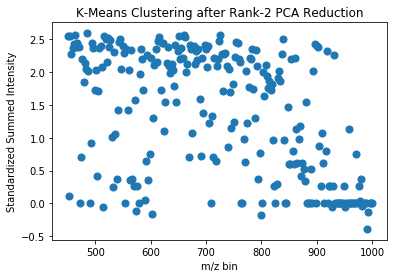

In [59]:
plt.scatter(x, y, s=50, cmap='viridis')
plt.title('K-Means Clustering after Rank-2 PCA Reduction')
plt.xlabel('m/z bin')
plt.ylabel('Standardized Summed Intensity')

In [61]:
df_control_feature_set_standardized.head()

,450.0,452.20883534136544,454.41767068273094,456.6265060240964,458.83534136546183,461.04417670682733,463.2530120481928,465.4618473895582,467.6706827309237,469.87951807228916,...,980.1204819277108,982.3293172690763,984.5381526104418,986.7469879518072,988.9558232931727,991.1646586345381,993.3734939759036,995.5823293172691,997.7911646586346,1000.0
0,0.928827,10.617636,0.610132,-0.293381,-0.31221,-0.034205,0.804553,-0.503369,-0.33669,-0.060366,...,-0.408177,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0,0.0
0,0.358183,6.094947,0.360997,-0.293381,-0.31221,0.019161,0.448514,-0.503369,-0.33669,-0.266148,...,3.384116,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0,0.0
0,-0.637789,-0.567337,-0.857177,-0.293381,-0.31221,-0.821566,-0.493169,-0.503369,-0.33669,-0.828612,...,-0.408177,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0,0.0
0,-0.183879,1.399723,-0.364067,-0.293381,-0.31221,-0.218896,0.590063,-0.503369,-0.33669,-0.316772,...,-0.408177,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0,0.0
0,-0.474041,-0.567337,-0.496392,-0.293381,-0.31221,-0.821566,-0.493169,-0.503369,-0.33669,-0.828612,...,-0.408177,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0,0.0
